In [1]:
import os

import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm_notebook as tqdm

import pickle
from joblib import dump, load

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("features1min.csv", index_col="Unnamed: 0")

In [3]:
df = df[["4018" in f for f in df.index]].copy()
df_nominal = df[df["is_nominal"]]#.drop(["is_nominal"], axis=1)
df_outlier = df[~df["is_nominal"]]


In [4]:
sorted(df.index)[:10]

['4018_2020-02-25--06-58-04567000',
 '4018_2020-03-16--04-49-06952000',
 '4018_2020-03-16--04-49-26952000',
 'nominal/4018_2020-02-13--03-36-15545000',
 'nominal/4018_2020-02-13--03-37-15545000',
 'nominal/4018_2020-02-13--03-38-15545000',
 'nominal/4018_2020-02-13--03-39-15545000',
 'nominal/4018_2020-02-13--03-42-15545000',
 'nominal/4018_2020-02-13--03-43-15545000',
 'nominal/4018_2020-02-13--03-44-15545000']

In [5]:
df_nominal.shape, df_outlier.shape

((2586, 40), (3, 40))

In [6]:
df_nominal = df_nominal.sample(frac=1)

frac = 0.8
split = int(frac * df_nominal.shape[0])

df_train = df_nominal.iloc[:split]
df_test = df_nominal.iloc[split:]

In [7]:
df_test.is_nominal.value_counts()

True    518
Name: is_nominal, dtype: int64

In [8]:
featuresToScale = df_train.drop(["is_nominal"], axis=1).columns
# sX = StandardScaler(copy=True)
# df_train.loc[:,featuresToScale] = sX.fit_transform(df_train[featuresToScale])
# df_test.loc[:,featuresToScale]  = sX.fit_transform(df_test[featuresToScale])

In [9]:
X_train = df_nominal.drop(["is_nominal"], axis=1)

In [10]:
df_test = pd.concat([df_test, df_outlier])
X_test = df_test.drop(["is_nominal"], axis=1)
y_test = df_test["is_nominal"].copy()

In [11]:
# clf = OneClassSVM(kernel="linear", nu=0.05)
clf = IsolationForest(n_estimators=1000, contamination=0)

In [12]:
clf.fit(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0,
                max_features=1.0, max_samples='auto', n_estimators=1000,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [13]:
# df_train["score"] = clf.decision_function(df_train[featuresToScale])
# df_test["score"]  = clf.decision_function(df_test[featuresToScale])
df_train["score"] = clf.score_samples(df_train[featuresToScale])
df_test["score"]  = clf.score_samples(df_test[featuresToScale])
# score_test_nominal   = clf.decision_function(df_test[df_test["is_nominal"]][featuresToScale])
# score_test_anomalous = clf.decision_function(df_test[~df_test["is_nominal"]][featuresToScale])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


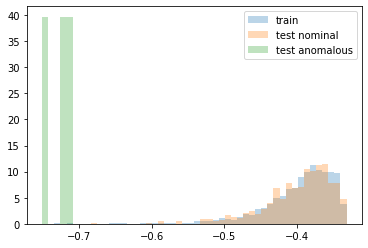

In [20]:
r = (pd.concat([df_train.score,df_test.score]).min(), pd.concat([df_train.score,df_test.score]).max())
a = 0.3
d = True

plt.figure()
plt.hist(df_train["score"],                        bins=50, range=r, alpha=a, density=d, label="train")
plt.hist(df_test[df_test["is_nominal"]]["score"],  bins=50, range=r, alpha=a, density=d, label="test nominal")
plt.hist(df_test[~df_test["is_nominal"]]["score"], bins=50, range=r, alpha=a, density=d, label="test anomalous")
plt.legend()
plt.show()

In [15]:
nominal = df_test[df_test["is_nominal"]]
anomaly = df_test[~df_test["is_nominal"]]

NSTEPS = 500

tns, tps, fns, fps = np.empty(NSTEPS), np.empty(NSTEPS), np.empty(NSTEPS), np.empty(NSTEPS)
thresholds = np.empty(NSTEPS)

low = df_test["score"].min()*1.2
high = df_test["score"].max()*1.2

print(low, high)
for i,t in enumerate(np.linspace(low, high, NSTEPS)):
#     print(t)
    tn = nominal[nominal["score"] >= t].shape[0]
    tp = anomaly[anomaly["score"] < t].shape[0]
    fn = anomaly[anomaly["score"] >= t].shape[0]
    fp = nominal[nominal["score"] < t].shape[0]

    tns[i] = tn
    tps[i] = tp
    fns[i] = fn
    fps[i] = fp
    thresholds[i] = t

-0.9011468765634869 -0.3994004115307665


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


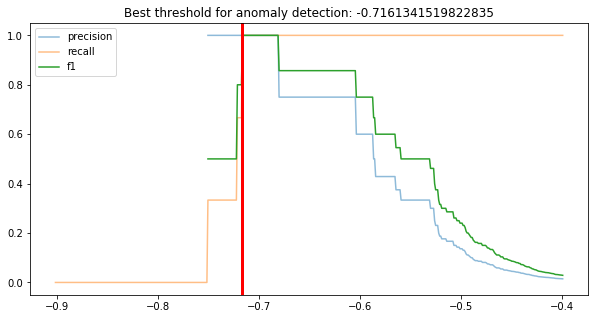

In [16]:
plt.figure(figsize=(10,5))
# plt.plot(thresholds, tps/(tps+fns), label="true positive rate")
# plt.plot(thresholds, tns/(tns+fps), label="true negative rate")
# plt.ylim(0.7,1.1)
precisions = tps/(tps+fps)
recalls    = tps/(tps+fns)
f1s        = 2*precisions*recalls/(precisions+recalls)

bestf1_ind = np.nanargmax(f1s)
bt = thresholds[bestf1_ind]

plt.plot(thresholds, precisions, alpha=0.5, label="precision")
plt.plot(thresholds, recalls,    alpha=0.5, label="recall")
plt.plot(thresholds, f1s, label="f1")
plt.axvline(bt, color="red", linewidth=3)

plt.title(f"Best threshold for anomaly detection: {bt}")

plt.legend()
plt.show()

In [17]:
dump({"model":clf, "threshold":bt}, "isoforest1min.gz")

['isoforest1min.gz']

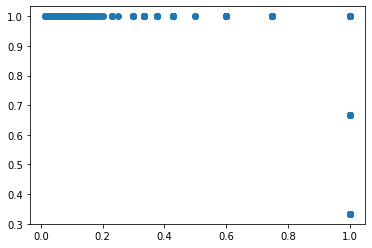

In [18]:
plt.figure()
plt.plot(precisions, recalls, "o")
plt.show()